# Music Generator
## COMP 432 Fall 2020
## Natalia Whiteley 40044353 and Michael Naccache 27...

In [184]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from music21 import *

In [134]:
VERBOSE = True
GENRES = ['sample']
INSTRUMENTS = [instrument.Piano, instrument.Bass, instrument.Guitar, instrument.Saxophone, instrument.Trumpet]
PALETTE = 'husl'

## Part 1: Import Dataset

Here we define some helper functions for loading files and parsing the midi format. Then, we load the midi files and thier genres.
The format we use to import the midi files is a list of every song, where each song is a dictionary of a track for each instrument. Each instrument track is a list of all the notes in the track.

ex. all_songs -> jazz_song_1 -> piano track -> A5, G2, B5, ...

In [152]:
# given the name of a midi file, returns a 2D array of notes per instrument
def import_midi(midi_file, verbose=VERBOSE):

    # parse midi file
    midi = converter.parse(midi_file)
  
    # seperate based on instrument
    midi_parts = instrument.partitionByInstrument(midi)

    notes = {}
    notes_to_parse = []

    for part in midi_parts.parts:
        # only use instruments we want
        if any(isinstance(part.getInstrument(), x) for x in INSTRUMENTS):
            notes[str(part.getInstrument().bestName())] = []
            notes_to_parse = part.recurse()

            # finding whether a particular element is note or a chord
            for element in notes_to_parse: 
                #note
                if isinstance(element, note.Note):
                    notes[str(part.getInstrument().bestName())].append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes[str(part.getInstrument().bestName())].append('.'.join(str(n.pitch) for n in element))

    # remove any empty instruments
    notes = {k: np.array(v) for k, v in notes.items() if v}

    if verbose:
        print('Finished importing {}.'.format(midi_file))

    return notes

# gets the path and label for every file in a directory and its sub-directories
def get_all_files_in_dir(dir_path, verbose=VERBOSE):
    midis = []
    genres = []

    for root, dirs, files in os.walk(dir_path):
        genre = os.path.basename(root)

        # if genre not in list, ignore it
        if genre in GENRES:
            # load all midi files in this directory
            for file in files:
                if file.endswith('.mid'):
                    midis.append(os.path.join(root, file))
                    genres.append(genre)
            
            if verbose:
                print('Loaded all {} midi files.'.format(genre))

    return midis, genres


In [153]:
midi_filenames, genres = get_all_files_in_dir('./midi_files')
songs = [import_midi(x) for x in midi_filenames]

Loaded all sample midi files.
Finished importing ./midi_files/sample/a_cottage_for_sale_rs.mid.
Finished importing ./midi_files/sample/2_of_a_kind_jp.mid.
Finished importing ./midi_files/sample/500_miles_high-Chick-Corea_ee.mid.
Finished importing ./midi_files/sample/a_day_in_the_life_of_a_fool_jhall.mid.


## Part 2: Data Analysis
Here we make some graphs for the distribution of genres and distributions of notes in each song to see what adjustements we need to make to the data.

From the genre distribution, jazz leads by a significant margin, meaning it would get the best results from training.

Text(0.5, 1.0, 'Genre Distribution')

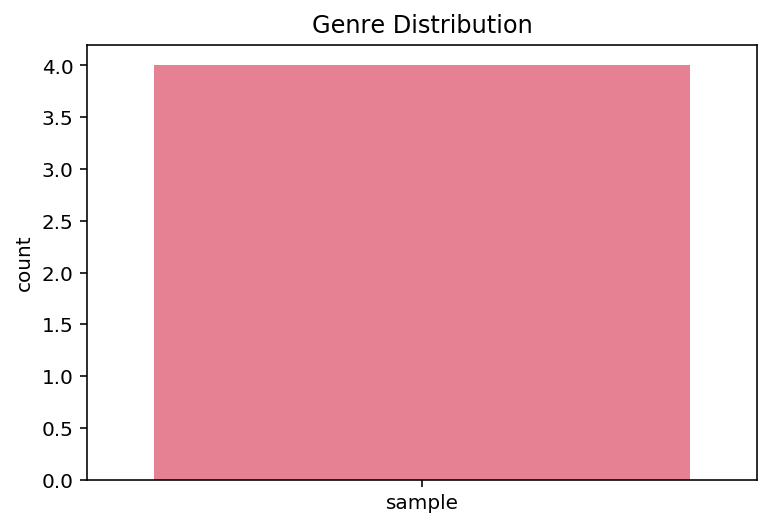

In [154]:
# graph distribution of genres
sns.countplot(genres, palette=PALETTE)
plt.title('Genre Distribution')

In [155]:
# graph note distribution in one song
def plot_notes_per_instrument(song, song_name):
    fig, ax = plt.subplots(len(song.keys()), 1, figsize=(10, 5))
    fig.suptitle('Note distribution in by instrument {}'.format(song_name))
    
    i = 0
    for instrument in song.keys():        
        sns.countplot(song[instrument], ax=ax[i], palette=PALETTE)
        ax[i].set_title(instrument)
        ax[i].tick_params(axis='x', labelsize=5, labelrotation=45)
        i += 1

With the note distributions, you can see that some instruments have an excess of notes played only a few times that don't add much to the general composition.

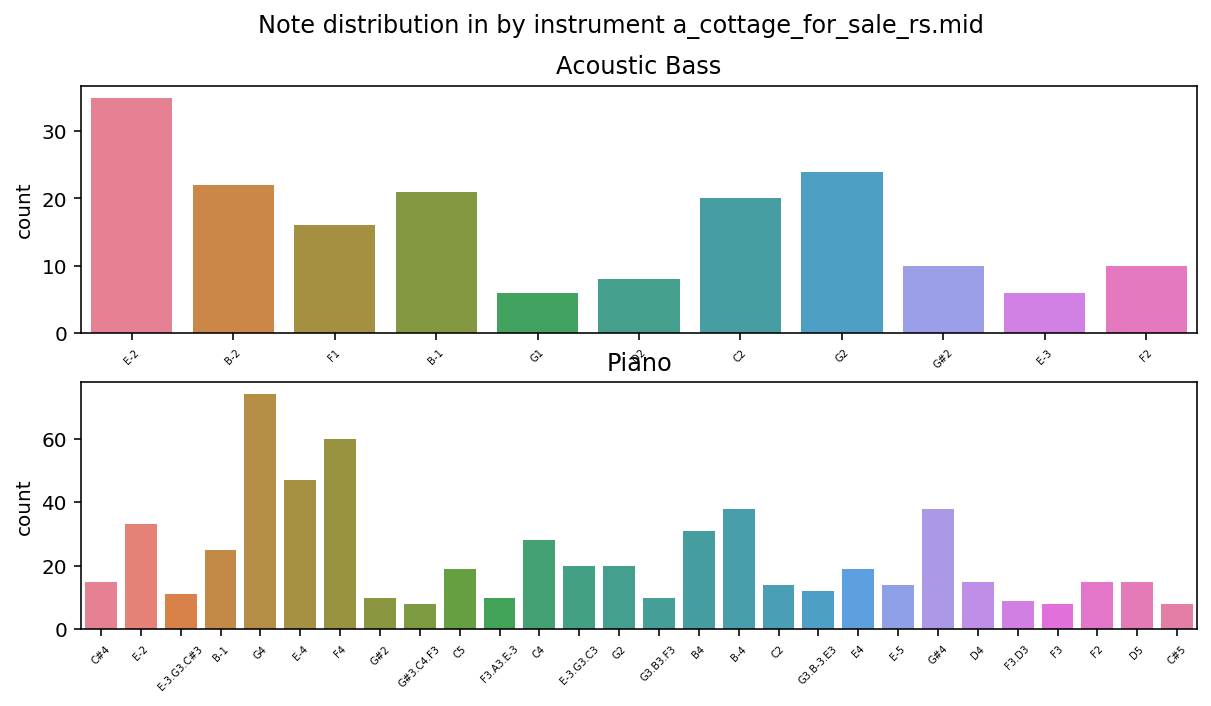

In [160]:
plot_notes_per_instrument(songs[0], os.path.basename(midi_filenames[0]))

## Part 3: Split and Normalize Dataset

In [161]:
# remove any unfrequent notes; ie. less than 10% of the max frequency
def remove_unfrequent_notes(song):
    # select each instrument track
    for instrument in song.keys():
        freq = Counter(song[instrument])

        # get the max feuquency of notes
        max_freq = freq.most_common(1)[0][1]

        # make list of all the significant notes
        frequent_notes = [note for note in song[instrument] if freq[note] >= max_freq * 0.10]
        new_song = []
        for note in song[instrument]:
            if note in frequent_notes:
                new_song.append(note)
        
        song[instrument] = new_song

    return song

# remove infrequent notes from songs
songs = [remove_unfrequent_notes(song) for song in songs]

In [175]:
# dictionaries to quickly convert between notes and ints and vice versa
note_to_int = {}
int_to_note = {}

def convert_song(song, reverse=False):
    new_song = {}

    # reverse is translating ints back to note strings
    if reverse:
        for instrument in song.keys():
            for note in song[instrument]:
                new_song[instrument].append(int_to_note[note])

    # translate note strings to ints
    else:
        for instrument in song.keys():
            new_song[instrument] = []
            for note in song[instrument]:
                # note already in dictionary
                if note in note_to_int:
                    new_song[instrument].append(note_to_int[note])
                # add note to both dictionaries
                else:
                    note_to_int[note] = len(note_to_int)
                    int_to_note[note_to_int[note]] = note
                    new_song[instrument].append(note_to_int[note])

    return new_song

In [181]:
# convert songs and genres from string categories to int categories
songs_int = [convert_song(song) for song in songs]

genres_to_int = dict((genre, number) for number, genre in enumerate(list(set(genres))))
genres_int = [genres_to_int[i] for i in genres]

In [187]:
# create X and y from int-encoded categories
X = np.array(songs_int)
y = np.array(genres_int)

# split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## Part 3: Train GAN With Magenta/Wavenet

## Part 5: Results

In [ ]:
# TODO: make function that compares notes in training data with generated results

## Sources

* https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/
* https://www.kaggle.com/wfaria/midi-music-data-extraction-using-music21